In [ ]:
# Notebook 5: Baseline Trading Strategy
# NIFTY Quantitative Trading System

"""
Implements EMA crossover strategy with regime filter:
- Long: EMA(5) crosses above EMA(15) in Uptrend (+1)
- Short: EMA(5) crosses below EMA(15) in Downtrend (-1)
- No trades in Sideways (0)
"""


In [1]:
# ============================================================================
# IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


In [2]:
# ============================================================================
# CONFIGURATION
# ============================================================================

DATA_DIR = Path('../data')
FEATURES_DIR = DATA_DIR / 'features'
RESULTS_DIR = Path('../results')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR = Path('../plots')

# Strategy parameters
INITIAL_CAPITAL = 100000  # ₹1,00,000
TRAIN_RATIO = 0.7

In [3]:
# ============================================================================
# LOAD DATA WITH REGIMES
# ============================================================================

print("="*70)
print("LOADING DATA")
print("="*70)

df = pd.read_csv(FEATURES_DIR / 'nifty_with_regimes.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"✓ Loaded data: {df.shape}")
print(f"  Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

# Split into train and test
train_size = int(len(df) * TRAIN_RATIO)
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

print(f"\nTrain: {len(train_df)} rows ({train_df['timestamp'].min()} to {train_df['timestamp'].max()})")
print(f"Test:  {len(test_df)} rows ({test_df['timestamp'].min()} to {test_df['timestamp'].max()})")


LOADING DATA
✓ Loaded data: (28880, 41)
  Date range: 2024-01-01 09:15:00 to 2025-01-14 15:30:00

Train: 20216 rows (2024-01-01 09:15:00 to 2024-09-22 15:30:00)
Test:  8664 rows (2024-09-23 09:15:00 to 2025-01-14 15:30:00)


In [4]:
spot_rename_map = {
    'open': 'open_spot',
    'high': 'high_spot',
    'low': 'low_spot',
    'volume': 'volume_spot'
}

train_df = train_df.rename(columns=spot_rename_map)
test_df  = test_df.rename(columns=spot_rename_map)


In [5]:
print(test_df['regime'].value_counts(normalize=True))


regime
-1    0.997461
 1    0.002539
Name: proportion, dtype: float64


In [6]:
# ============================================================================
# TASK 4.1: STRATEGY IMPLEMENTATION
# ============================================================================

print("\n" + "="*70)
print("TASK 4.1: STRATEGY IMPLEMENTATION")
print("="*70)

def generate_signals(df):
    """
    Generate trading signals based on EMA crossover and regime
    """
    signals = df.copy()
    
    # Initialize columns
    signals['position'] = 0  # 0: No position, 1: Long, -1: Short
    signals['signal'] = 0    # Trade signal
    signals['entry_price'] = 0.0
    signals['exit_price'] = 0.0
    
    # Detect EMA crossovers
    signals['ema_cross_up'] = (
        (signals['ema_5'] > signals['ema_15']) & 
        (signals['ema_5'].shift(1) <= signals['ema_15'].shift(1))
    )
    
    signals['ema_cross_down'] = (
        (signals['ema_5'] < signals['ema_15']) & 
        (signals['ema_5'].shift(1) >= signals['ema_15'].shift(1))
    )
    
    # Track trades
    trades = []
    position = 0  # Current position
    entry_price = 0
    entry_time = None
    entry_regime = 0
    
    for i in range(1, len(signals)):
        row = signals.iloc[i]
        prev_row = signals.iloc[i-1]
        
        # LONG ENTRY: EMA cross up in Uptrend
        if row['ema_cross_up'] and row['regime'] == 1 and position == 0:
            position = 1
            entry_price = row['open_spot']  # Enter at next candle open
            entry_time = row['timestamp']
            entry_regime = row['regime']
            signals.loc[i, 'signal'] = 1
            
        # LONG EXIT: EMA cross down
        elif row['ema_cross_down'] and position == 1:
            exit_price = row['open_spot']
            pnl = exit_price - entry_price
            pnl_pct = (pnl / entry_price) * 100
            
            trades.append({
                'entry_time': entry_time,
                'exit_time': row['timestamp'],
                'entry_price': entry_price,
                'exit_price': exit_price,
                'direction': 'LONG',
                'entry_regime': entry_regime,
                'exit_regime': row['regime'],
                'pnl': pnl,
                'pnl_pct': pnl_pct,
                'duration_candles': i - signals[signals['timestamp'] == entry_time].index[0],
                'entry_ema_gap': signals.loc[signals['timestamp'] == entry_time, 'ema_gap'].iloc[0],
                'entry_iv': signals.loc[signals['timestamp'] == entry_time, 'avg_iv'].iloc[0],
                'entry_pcr': signals.loc[signals['timestamp'] == entry_time, 'pcr_oi'].iloc[0],
            })
            
            position = 0
            signals.loc[i, 'signal'] = -1
        
        # SHORT ENTRY: EMA cross down in Downtrend
        elif row['ema_cross_down'] and row['regime'] == -1 and position == 0:
            position = -1
            entry_price = row['open_spot']
            entry_time = row['timestamp']
            entry_regime = row['regime']
            signals.loc[i, 'signal'] = -1
            
        # SHORT EXIT: EMA cross up
        elif row['ema_cross_up'] and position == -1:
            exit_price = row['open_spot']
            pnl = entry_price - exit_price  # Reversed for short
            pnl_pct = (pnl / entry_price) * 100
            
            trades.append({
                'entry_time': entry_time,
                'exit_time': row['timestamp'],
                'entry_price': entry_price,
                'exit_price': exit_price,
                'direction': 'SHORT',
                'entry_regime': entry_regime,
                'exit_regime': row['regime'],
                'pnl': pnl,
                'pnl_pct': pnl_pct,
                'duration_candles': i - signals[signals['timestamp'] == entry_time].index[0],
                'entry_ema_gap': signals.loc[signals['timestamp'] == entry_time, 'ema_gap'].iloc[0],
                'entry_iv': signals.loc[signals['timestamp'] == entry_time, 'avg_iv'].iloc[0],
                'entry_pcr': signals.loc[signals['timestamp'] == entry_time, 'pcr_oi'].iloc[0],
            })
            
            position = 0
            signals.loc[i, 'signal'] = 1
        
        signals.loc[i, 'position'] = position
    
    return signals, pd.DataFrame(trades)

print("Generating signals for training data...")
train_signals, train_trades = generate_signals(train_df)
print(f"✓ Training trades: {len(train_trades)}")

print("\nGenerating signals for test data...")
test_signals, test_trades = generate_signals(test_df)
print(f"✓ Test trades: {len(test_trades)}")


TASK 4.1: STRATEGY IMPLEMENTATION
Generating signals for training data...
✓ Training trades: 337

Generating signals for test data...
✓ Test trades: 313


In [7]:
# ============================================================================
# TASK 4.2: BACKTESTING & METRICS
# ============================================================================

print("\n" + "="*70)
print("TASK 4.2: BACKTESTING & PERFORMANCE METRICS")
print("="*70)

def calculate_metrics(trades_df, dataset_name=""):
    """Calculate comprehensive performance metrics"""
    
    if len(trades_df) == 0:
        print(f"No trades for {dataset_name}")
        return {}
    
    # Basic metrics
    total_trades = len(trades_df)
    winning_trades = len(trades_df[trades_df['pnl'] > 0])
    losing_trades = len(trades_df[trades_df['pnl'] < 0])
    
    # Returns
    total_return = trades_df['pnl_pct'].sum()
    
    # Win rate
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    
    # Profit factor
    gross_profit = trades_df[trades_df['pnl'] > 0]['pnl'].sum()
    gross_loss = abs(trades_df[trades_df['pnl'] < 0]['pnl'].sum())
    profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf
    
    # Average trade
    avg_win = trades_df[trades_df['pnl'] > 0]['pnl_pct'].mean() if winning_trades > 0 else 0
    avg_loss = trades_df[trades_df['pnl'] < 0]['pnl_pct'].mean() if losing_trades > 0 else 0
    
    # Drawdown
    cumulative_returns = (1 + trades_df['pnl_pct']/100).cumprod()
    running_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min() * 100
    
    # Sharpe Ratio (annualized)
    returns = trades_df['pnl_pct']
    trading_days_per_year = 252
    candles_per_day = 78  # 5-min candles in trading day
    avg_return = returns.mean()
    std_return = returns.std()
    sharpe_ratio = np.sqrt(trading_days_per_year * candles_per_day) * (avg_return / std_return) if std_return > 0 else 0
    
    # Sortino Ratio (downside deviation)
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std()
    sortino_ratio = np.sqrt(trading_days_per_year * candles_per_day) * (avg_return / downside_std) if downside_std > 0 else 0
    
    # Calmar Ratio
    annualized_return = total_return * (trading_days_per_year / (len(trades_df) / (candles_per_day)))
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Average trade duration
    avg_duration = trades_df['duration_candles'].mean() * 5  # Convert to minutes
    
    metrics = {
        'Total Trades': total_trades,
        'Winning Trades': winning_trades,
        'Losing Trades': losing_trades,
        'Win Rate (%)': win_rate * 100,
        'Total Return (%)': total_return,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Calmar Ratio': calmar_ratio,
        'Max Drawdown (%)': max_drawdown,
        'Profit Factor': profit_factor,
        'Avg Win (%)': avg_win,
        'Avg Loss (%)': avg_loss,
        'Avg Trade Duration (min)': avg_duration,
        'Gross Profit': gross_profit,
        'Gross Loss': gross_loss,
    }
    
    return metrics

# Calculate metrics
train_metrics = calculate_metrics(train_trades, "Training")
test_metrics = calculate_metrics(test_trades, "Test")

# Display metrics
print("\n" + "="*70)
print("BASELINE STRATEGY PERFORMANCE")
print("="*70)

metrics_comparison = pd.DataFrame({
    'Training': train_metrics,
    'Test': test_metrics
})

print("\n", metrics_comparison.round(4))

# Save metrics
metrics_comparison.to_csv(RESULTS_DIR / 'baseline_metrics.csv')
print(f"\n✓ Saved: baseline_metrics.csv")

# Save trades
train_trades.to_csv(RESULTS_DIR / 'baseline_train_trades.csv', index=False)
test_trades.to_csv(RESULTS_DIR / 'baseline_test_trades.csv', index=False)
print(f"✓ Saved: baseline_train_trades.csv")
print(f"✓ Saved: baseline_test_trades.csv")


TASK 4.2: BACKTESTING & PERFORMANCE METRICS

BASELINE STRATEGY PERFORMANCE

                              Training         Test
Total Trades                 337.0000     313.0000
Winning Trades               102.0000      98.0000
Losing Trades                235.0000     215.0000
Win Rate (%)                  30.2671      31.3099
Total Return (%)             -80.3134      11.4120
Sharpe Ratio                 -10.5504       1.3454
Sortino Ratio                -35.7265       5.3821
Calmar Ratio                 -75.2649      14.1601
Max Drawdown (%)             -62.2387     -50.6115
Profit Factor                  0.8390       1.0700
Avg Win (%)                    3.4268       4.0722
Avg Loss (%)                  -1.8291      -1.8031
Avg Trade Duration (min)      64.8368 -101008.8339
Gross Profit              274677.6036  522521.8567
Gross Loss                327375.3192  488342.7908

✓ Saved: baseline_metrics.csv
✓ Saved: baseline_train_trades.csv
✓ Saved: baseline_test_trades.csv


In [8]:
# ============================================================================
# VISUALIZATIONS
# ============================================================================

print("\n" + "="*70)
print("CREATING VISUALIZATIONS")
print("="*70)

# 1. Equity Curve with Drawdown
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Test trades only for visualization
if len(test_trades) > 0:
    test_trades['cumulative_pnl'] = test_trades['pnl'].cumsum()
    test_trades['equity'] = INITIAL_CAPITAL + test_trades['cumulative_pnl']
    test_trades['cumulative_return'] = (1 + test_trades['pnl_pct']/100).cumprod()
    
    # Running max for drawdown
    test_trades['running_max'] = test_trades['cumulative_return'].cumsum().expanding().max()
    test_trades['drawdown'] = (test_trades['cumulative_return'].cumsum() - test_trades['running_max']) / test_trades['running_max'] * 100
    
    # Equity curve
    axes[0].plot(test_trades['exit_time'], test_trades['equity'], 
                color='blue', linewidth=2, label='Equity')
    axes[0].axhline(y=INITIAL_CAPITAL, color='gray', linestyle='--', 
                   label='Initial Capital', alpha=0.5)
    axes[0].set_title('Equity Curve (Test Period)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Portfolio Value (₹)', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Drawdown
    axes[1].fill_between(test_trades['exit_time'], test_trades['drawdown'], 0,
                        color='red', alpha=0.3, label='Drawdown')
    axes[1].set_title('Drawdown', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('Drawdown (%)', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'baseline_equity_curve.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: baseline_equity_curve.png")
    plt.close()

# 2. Trade Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

if len(test_trades) > 0:
    # PnL distribution
    axes[0, 0].hist(test_trades['pnl_pct'], bins=30, alpha=0.7, 
                   edgecolor='black', color='skyblue')
    axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[0, 0].set_title('PnL Distribution', fontweight='bold')
    axes[0, 0].set_xlabel('PnL (%)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Duration distribution
    axes[0, 1].hist(test_trades['duration_candles'] * 5, bins=30, 
                   alpha=0.7, edgecolor='black', color='lightgreen')
    axes[0, 1].set_title('Trade Duration Distribution', fontweight='bold')
    axes[0, 1].set_xlabel('Duration (minutes)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Win/Loss by regime
    regime_performance = test_trades.groupby('entry_regime')['pnl'].apply(
        lambda x: (x > 0).sum() / len(x) * 100 if len(x) > 0 else 0
    )
    axes[1, 0].bar(regime_performance.index, regime_performance.values, 
                  color=['red', 'yellow', 'green'], alpha=0.7)
    axes[1, 0].set_title('Win Rate by Entry Regime', fontweight='bold')
    axes[1, 0].set_xlabel('Regime')
    axes[1, 0].set_ylabel('Win Rate (%)')
    axes[1, 0].set_xticks([-1, 0, 1])
    axes[1, 0].set_xticklabels(['Downtrend', 'Sideways', 'Uptrend'])
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Long vs Short performance
    direction_perf = test_trades.groupby('direction')['pnl_pct'].sum()
    axes[1, 1].bar(direction_perf.index, direction_perf.values, 
                  color=['salmon', 'lightblue'], alpha=0.7)
    axes[1, 1].set_title('Cumulative Return by Direction', fontweight='bold')
    axes[1, 1].set_xlabel('Direction')
    axes[1, 1].set_ylabel('Cumulative Return (%)')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / 'baseline_trade_analysis.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: baseline_trade_analysis.png")
    plt.close()

# 3. Price with signals
fig, ax = plt.subplots(figsize=(16, 8))

# Plot price
ax.plot(test_df['timestamp'], test_df['close_spot'], 
        color='black', linewidth=1, label='Price', alpha=0.7)

# Plot EMAs
ax.plot(test_df['timestamp'], test_df['ema_5'], 
        color='blue', linewidth=1.5, label='EMA(5)', alpha=0.8)
ax.plot(test_df['timestamp'], test_df['ema_15'], 
        color='red', linewidth=1.5, label='EMA(15)', alpha=0.8)

# Mark entry/exit points
long_entries = test_trades[test_trades['direction'] == 'LONG']
short_entries = test_trades[test_trades['direction'] == 'SHORT']

ax.scatter(long_entries['entry_time'], long_entries['entry_price'],
          marker='^', color='green', s=100, label='Long Entry', zorder=5)
ax.scatter(short_entries['entry_time'], short_entries['entry_price'],
          marker='v', color='red', s=100, label='Short Entry', zorder=5)

ax.set_title('NIFTY Price with Trading Signals (Test Period)', 
            fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'baseline_signals.png', dpi=300, bbox_inches='tight')
print("✓ Saved: baseline_signals.png")
plt.close()




CREATING VISUALIZATIONS
✓ Saved: baseline_equity_curve.png
✓ Saved: baseline_trade_analysis.png
✓ Saved: baseline_signals.png



DISPLAYING BASELINE STRATEGY VISUALIZATIONS

📊 baseline_equity_curve.png


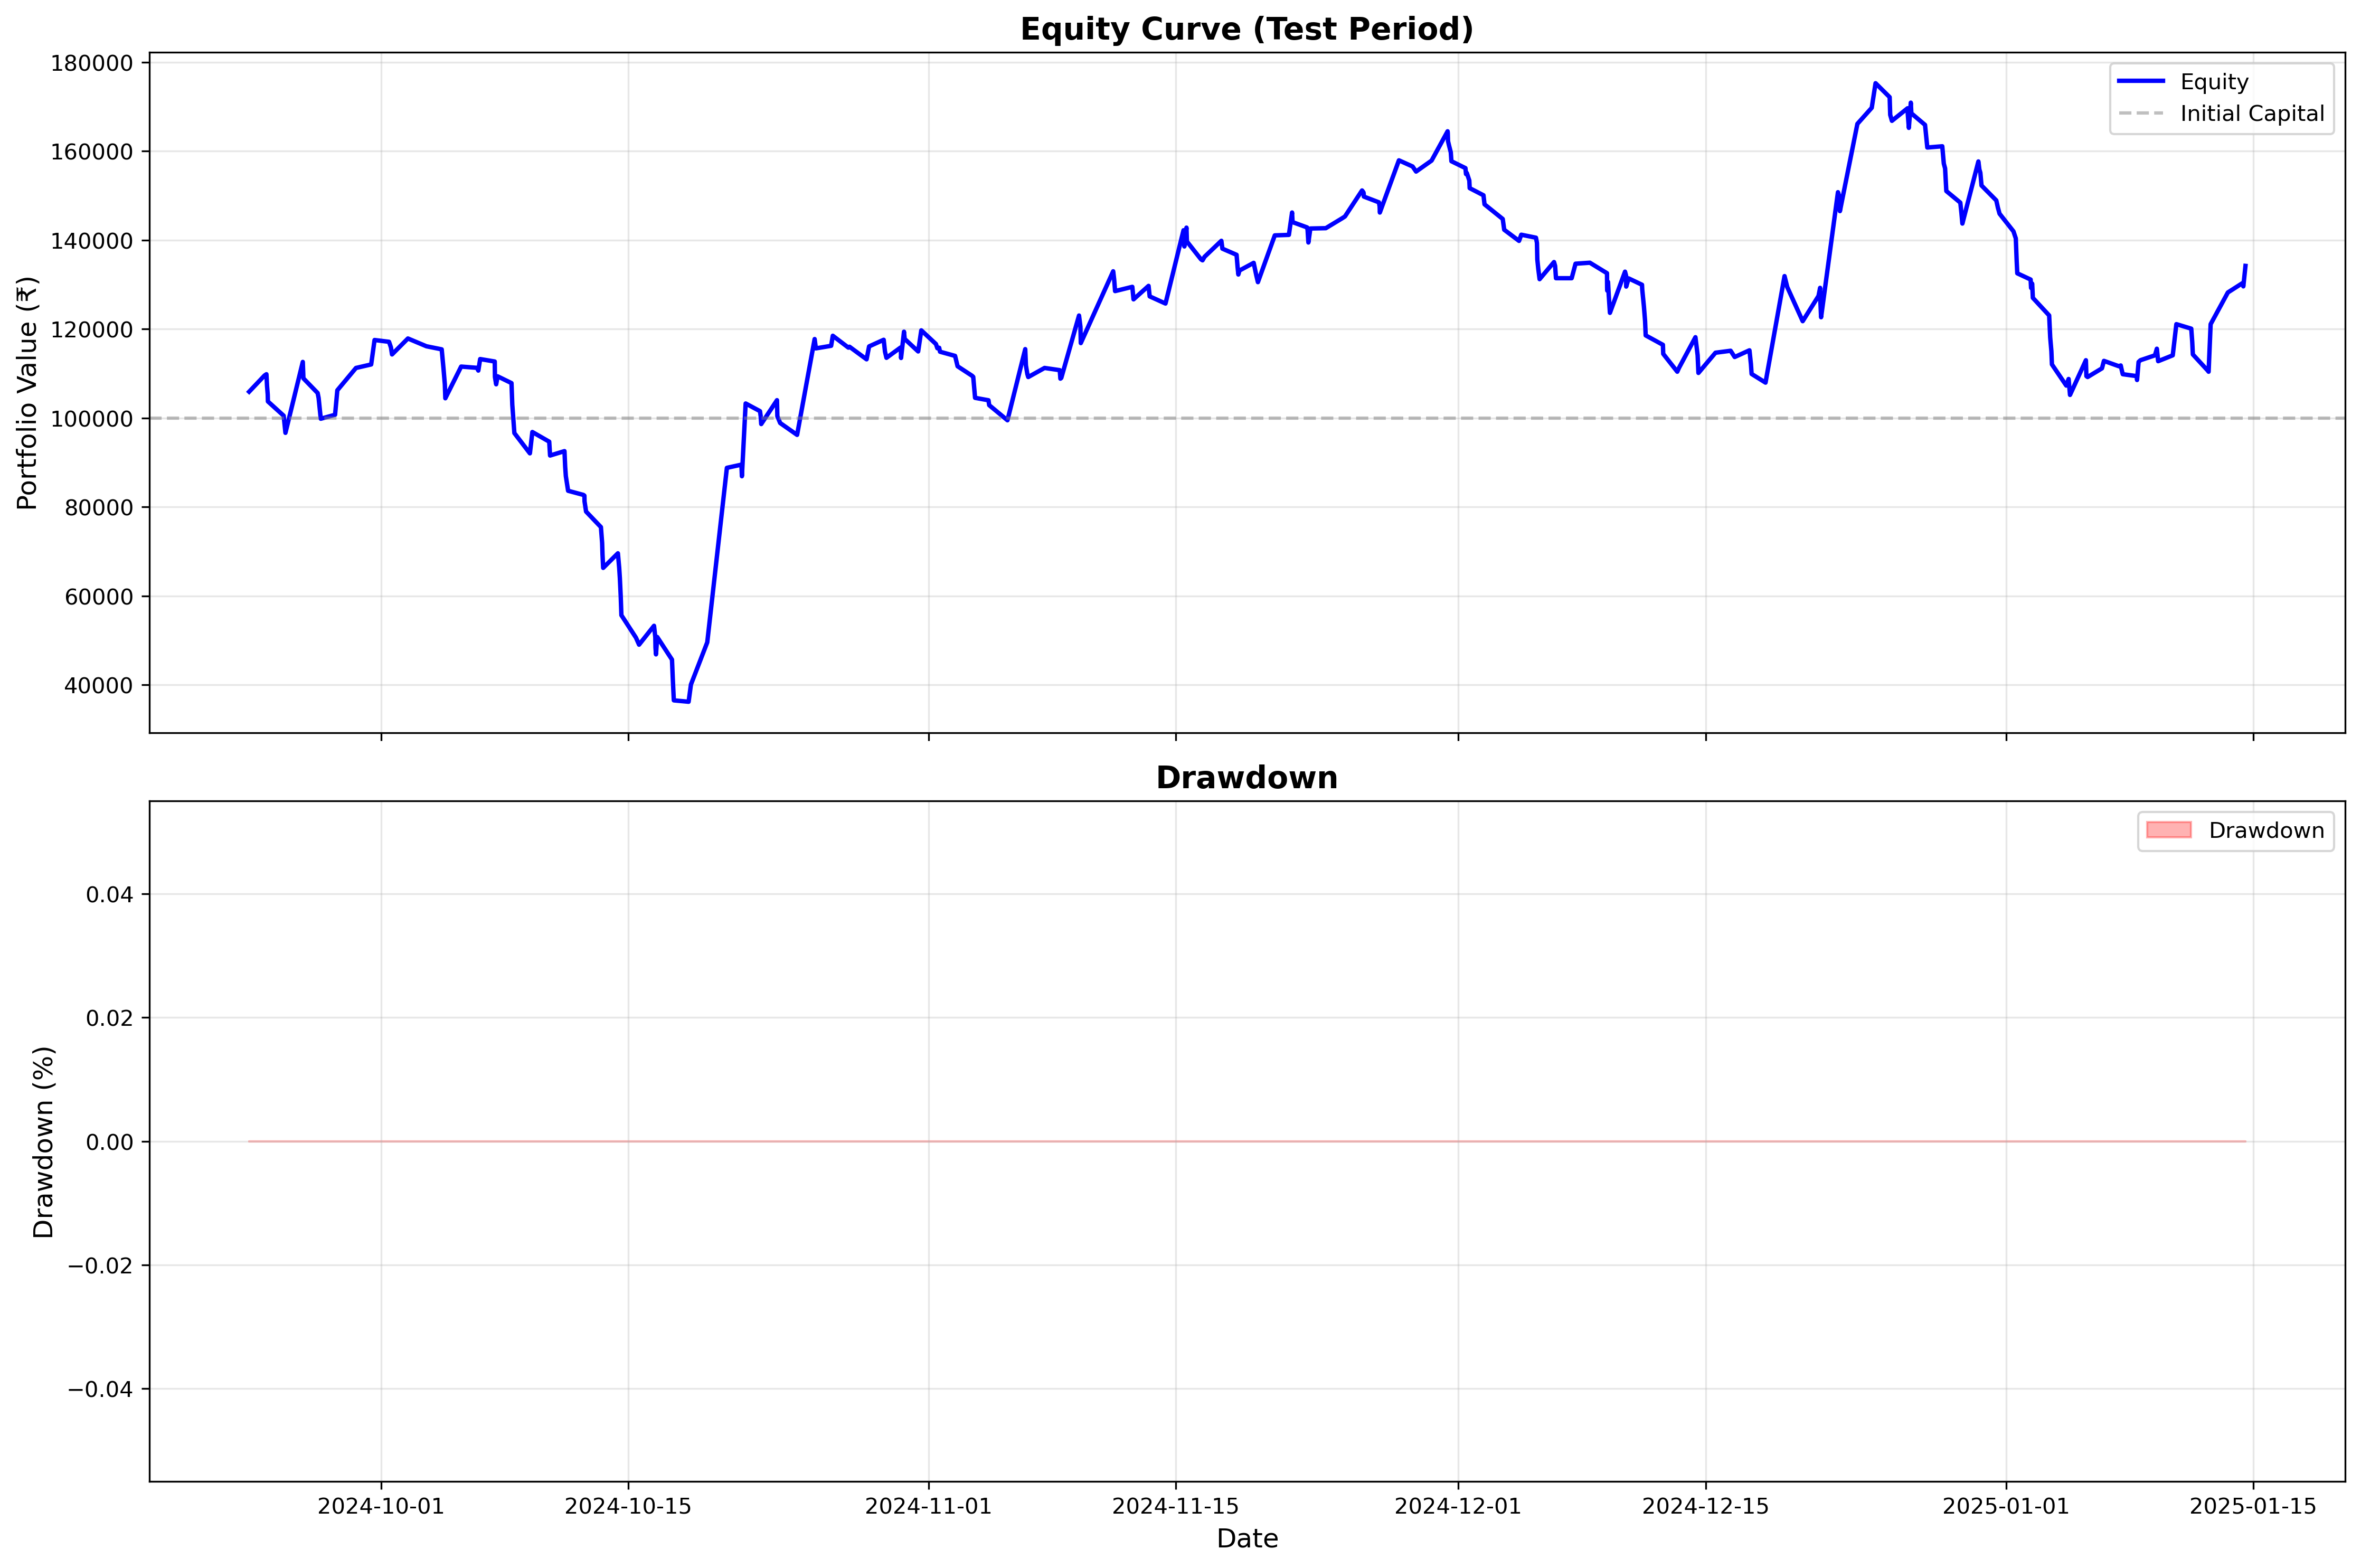


📊 baseline_trade_analysis.png


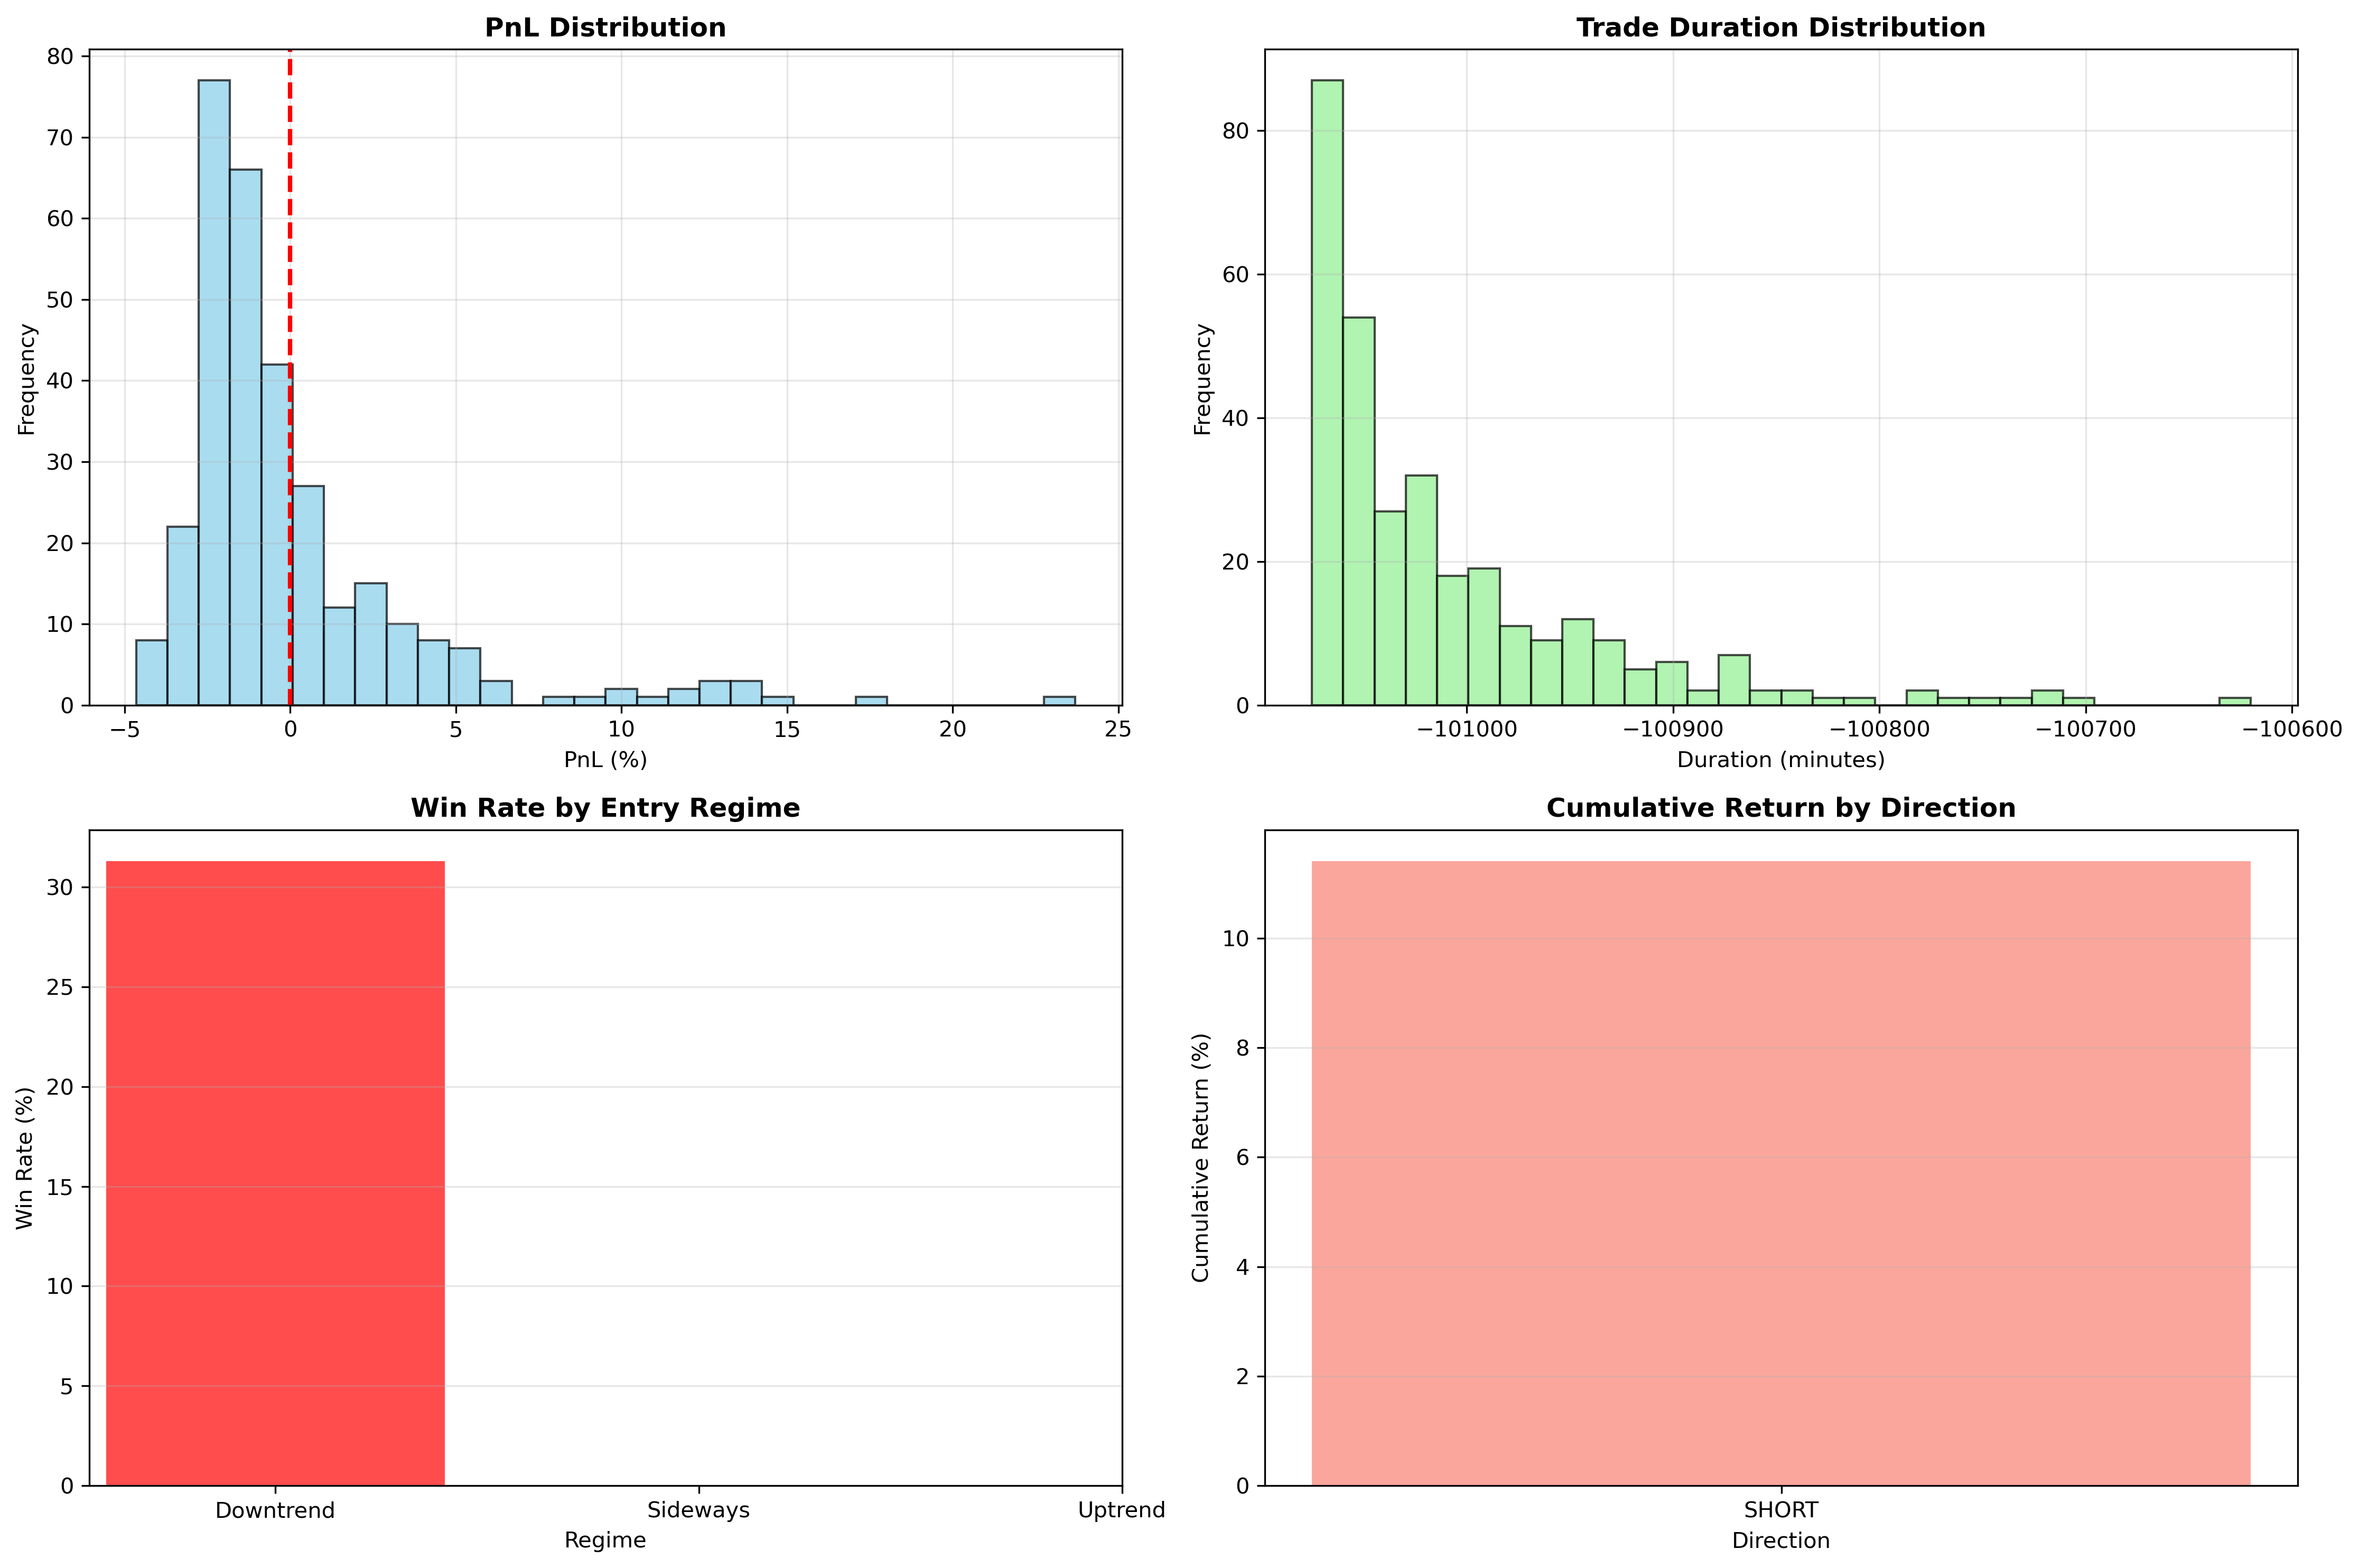


📊 baseline_signals.png


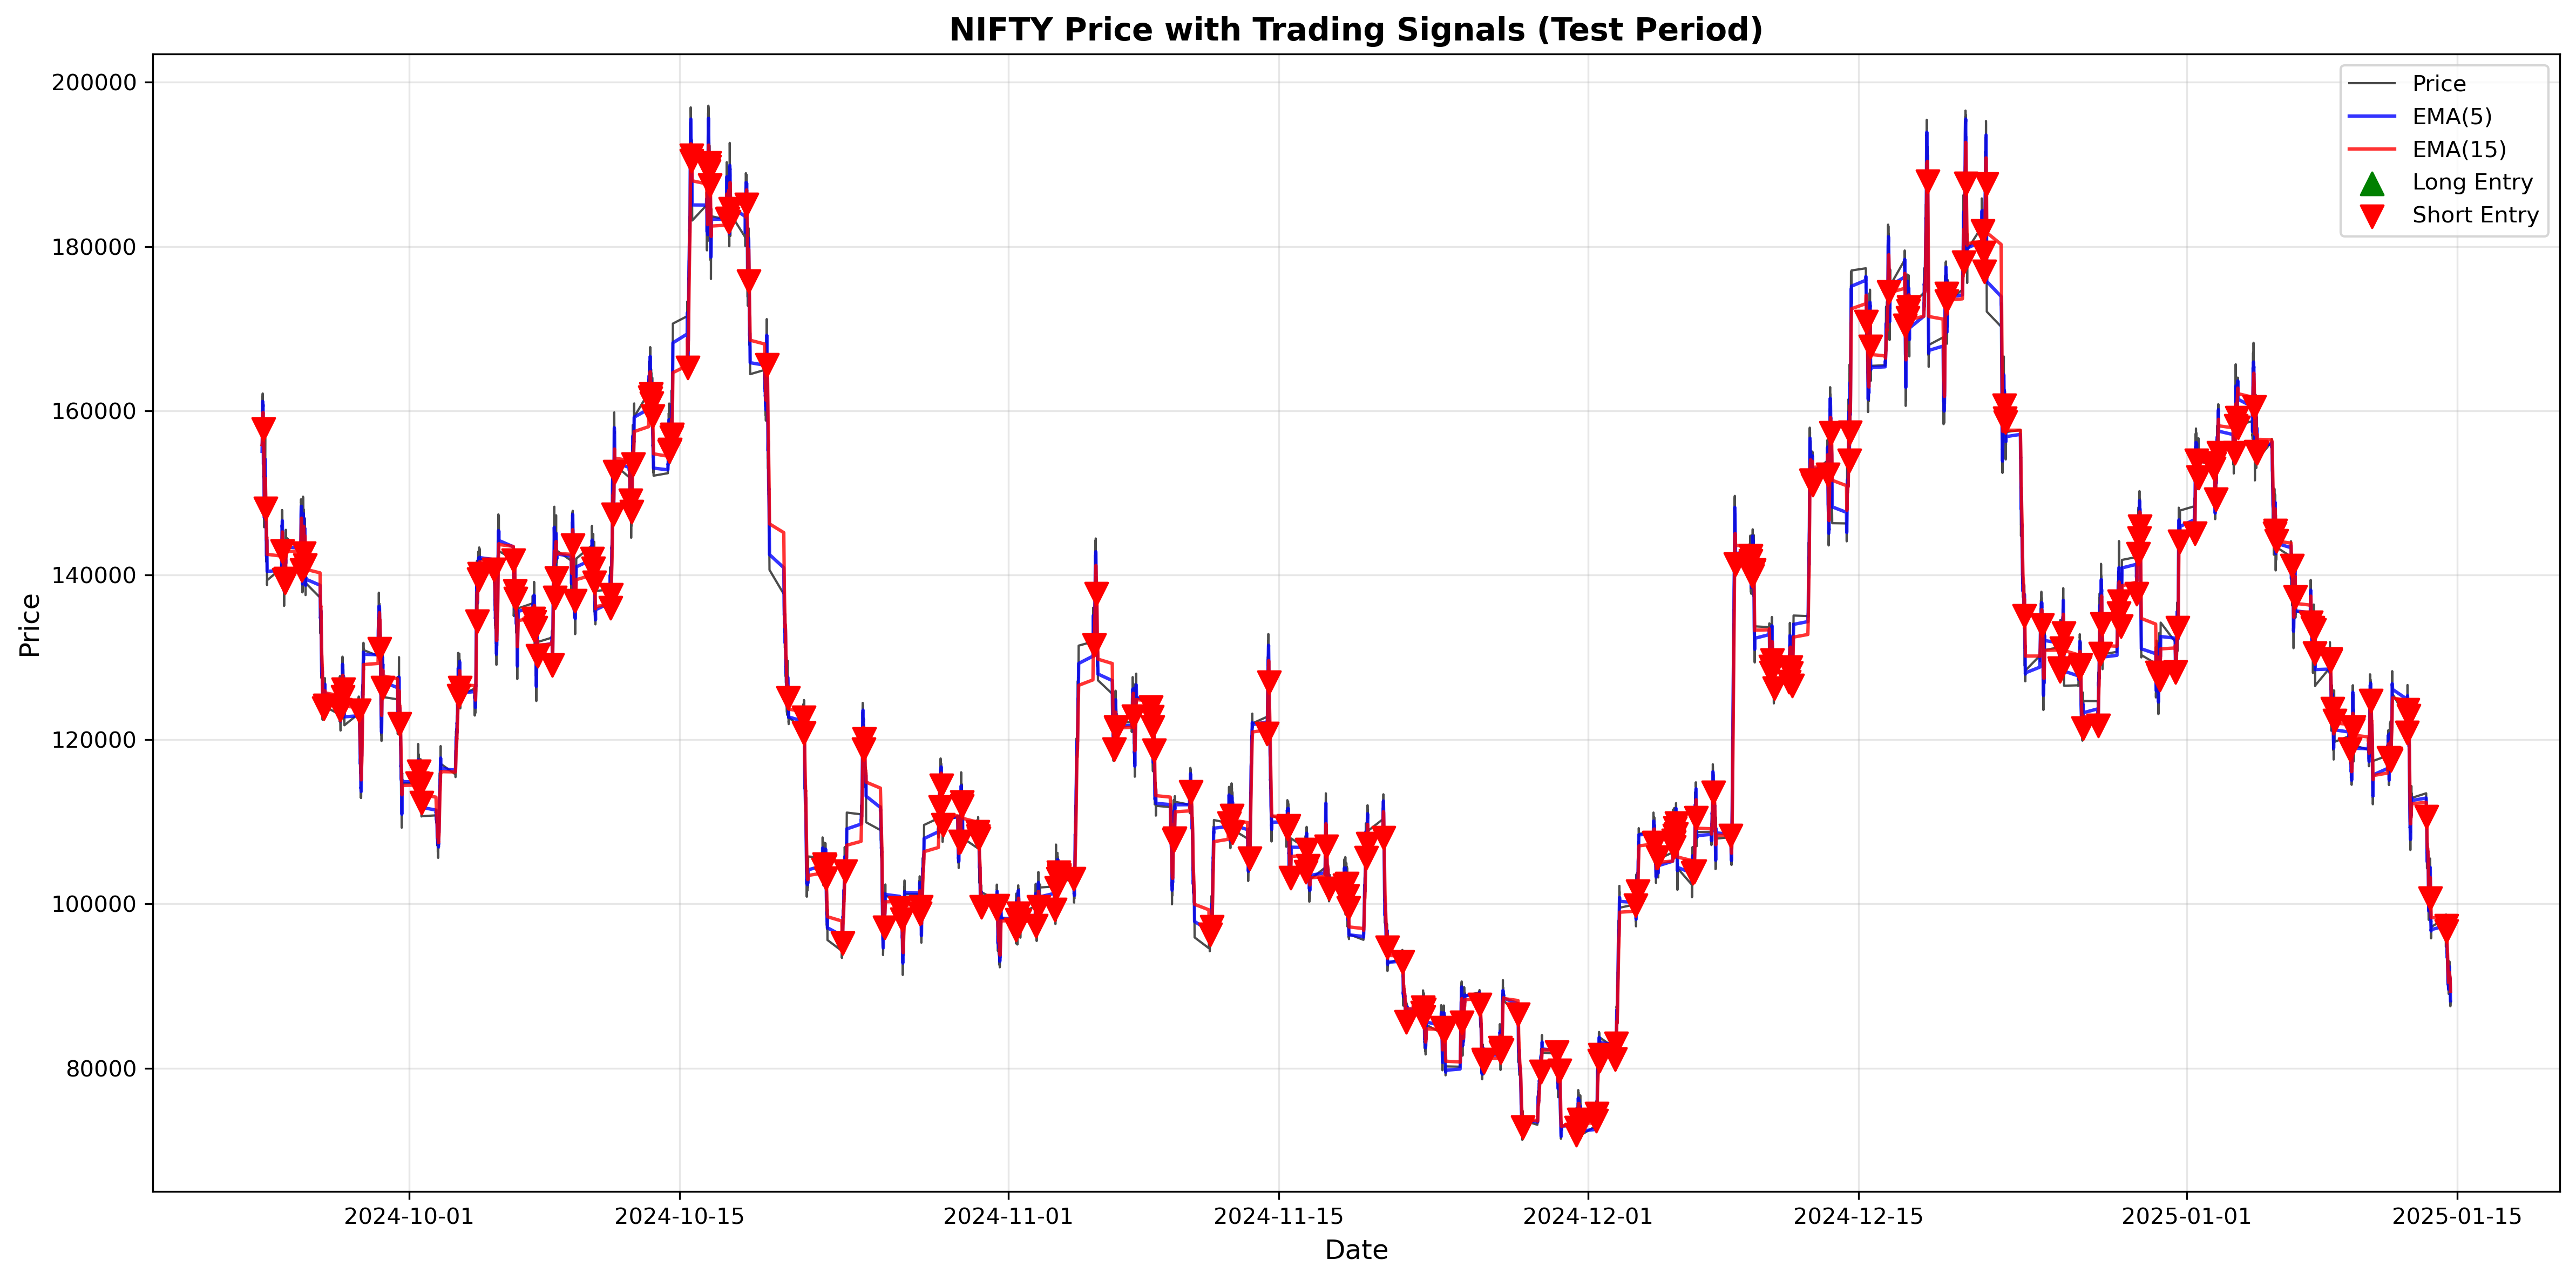

In [10]:
from IPython.display import Image, display

print("\n" + "="*70)
print("DISPLAYING BASELINE STRATEGY VISUALIZATIONS")
print("="*70)

baseline_plots = [
    'baseline_equity_curve.png',
    'baseline_trade_analysis.png',
    'baseline_signals.png'
]

for plot_name in baseline_plots:
    plot_path = PLOTS_DIR / plot_name
    if plot_path.exists():
        print(f"\n📊 {plot_name}")
        display(Image(filename=str(plot_path)))


In [9]:
# ============================================================================
# TRADE ANALYSIS
# ============================================================================

print("\n" + "="*70)
print("TRADE ANALYSIS")
print("="*70)

if len(test_trades) > 0:
    print("\nTrade Statistics:")
    print(f"  Total trades: {len(test_trades)}")
    print(f"  Long trades: {len(test_trades[test_trades['direction'] == 'LONG'])}")
    print(f"  Short trades: {len(test_trades[test_trades['direction'] == 'SHORT'])}")
    print(f"  Winning trades: {len(test_trades[test_trades['pnl'] > 0])}")
    print(f"  Losing trades: {len(test_trades[test_trades['pnl'] < 0])}")
    
    print("\nRegime Distribution:")
    print(test_trades['entry_regime'].value_counts().sort_index())
    
    print("\nTop 5 Winners:")
    print(test_trades.nlargest(5, 'pnl_pct')[['entry_time', 'direction', 
                                               'entry_regime', 'pnl_pct']])
    
    print("\nTop 5 Losers:")
    print(test_trades.nsmallest(5, 'pnl_pct')[['entry_time', 'direction', 
                                                'entry_regime', 'pnl_pct']])

print("\n" + "="*70)
print("BASELINE STRATEGY COMPLETE")
print("="*70)
print("\nNext Step: Run notebook 06_ml_models.ipynb")
print("="*70)


TRADE ANALYSIS

Trade Statistics:
  Total trades: 313
  Long trades: 0
  Short trades: 313
  Winning trades: 98
  Losing trades: 215

Regime Distribution:
entry_regime
-1.0    313
Name: count, dtype: int64

Top 5 Winners:
             entry_time direction  entry_regime    pnl_pct
73  2024-10-19 12:35:00     SHORT          -1.0  23.692264
84  2024-10-24 13:25:00     SHORT          -1.0  17.946019
240 2024-12-21 14:50:00     SHORT          -1.0  14.988358
127 2024-11-10 10:55:00     SHORT          -1.0  14.209708
169 2024-11-27 09:15:00     SHORT          -1.0  13.567536

Top 5 Losers:
             entry_time direction  entry_regime   pnl_pct
37  2024-10-08 12:40:00     SHORT          -1.0 -4.652763
235 2024-12-20 11:10:00     SHORT          -1.0 -4.314843
255 2024-12-27 12:30:00     SHORT          -1.0 -3.898542
139 2024-11-16 09:45:00     SHORT          -1.0 -3.867689
259 2024-12-28 13:55:00     SHORT          -1.0 -3.805583

BASELINE STRATEGY COMPLETE

Next Step: Run notebook 06_ml_m